A nonlinear neural network collaborative filtering model. 

It uses a partially observed interaction matrix as the input, aiming to reconstruct a completed rating matrix. In the meantime, the missing entries of the input are filled in the output layer via reconstruction for the purpose of recommendation.

There are two variants of AutoRec: user-based and item-based.

### Model

$h(\mathbf{R}_{*i}) = f(\mathbf{W} \cdot g(\mathbf{V} \mathbf{R}_{*i} + \mu) + b)$, where $h(\mathbf{R}_{*i})$ is the reconstruction of the  column of the rating matrix.

$\underset{\mathbf{W},\mathbf{V},\mu, b}{\mathrm{argmin}} \sum_{i=1}^M{\parallel \mathbf{R}_{*i} - h(\mathbf{R}_{*i})\parallel_{\mathcal{O}}^2} +\lambda(\| \mathbf{W} \|_F^2 + \| \mathbf{V}\|_F^2)$, where $\| \cdot \|_{\mathcal{O}}$ means only the contribution of observed ratings are considered, that is, only weights that are associated with observed inputs are updated during back-propagation.

### GPU Support

In [ ]:
!pip uninstall mxnet

In [ ]:
!pip install mxnet-cu101==1.7.0

In [ ]:
!pip install d2l==0.17.5

In [1]:
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

### Implementing the Model

In [2]:
class AutoRec(nn.Block):
    def __init__(self, num_hidden, num_users, dropout=0.05):
        super(AutoRec, self).__init__()
        self.encoder = nn.Dense(num_hidden, activation='sigmoid',
                                use_bias=True)
        self.decoder = nn.Dense(num_users, use_bias=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        hidden = self.dropout(self.encoder(input))
        pred = self.decoder(hidden)
        if autograd.is_training():  # Mask the gradient during training
            return pred * np.sign(input)
        else:
            return pred

### Reimplementing the Evaluator

In [3]:
def evaluator(network, inter_matrix, test_data, devices):
    scores = []
    for values in inter_matrix:
        feat = gluon.utils.split_and_load(values, devices, even_split=False)
        scores.extend([network(i).asnumpy() for i in feat])
    recons = np.array([item for sublist in scores for item in sublist])
    # Calculate the test RMSE
    rmse = np.sqrt(np.sum(np.square(test_data - np.sign(test_data) * recons))
                   / np.sum(np.sign(test_data)))
    return float(rmse)

### Training and Evaluating the Model

train loss 0.000, test RMSE 0.898
53386361.2 examples/sec on [gpu(0)]


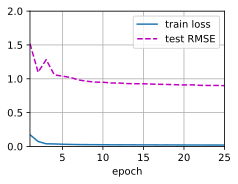

In [4]:
devices = d2l.try_all_gpus()
# Load the MovieLens 100K dataset
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items)
_, _, _, train_inter_mat = d2l.load_data_ml100k(train_data, num_users,
                                                num_items)
_, _, _, test_inter_mat = d2l.load_data_ml100k(test_data, num_users,
                                               num_items)
train_iter = gluon.data.DataLoader(train_inter_mat, shuffle=True,
                                   last_batch="rollover", batch_size=256,
                                   num_workers=d2l.get_dataloader_workers())
test_iter = gluon.data.DataLoader(np.array(train_inter_mat), shuffle=False,
                                  last_batch="keep", batch_size=1024,
                                  num_workers=d2l.get_dataloader_workers())
# Model initialization, training, and evaluation
net = AutoRec(500, num_users)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 25, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
d2l.train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices, evaluator, inter_mat=test_inter_mat)